## Introduction

### Parameters

In [20]:
import pandas as pd
import numpy as np
import logging
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, confusion_matrix, balanced_accuracy_score
from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
import plotly.express as px
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
import threading
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer


%matplotlib inline
np.random.seed(0)
random_state = 42
print_lock = threading.Lock()

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [21]:
noises = [0, 0.2, 0.4, 0.6, 0.8]

n_estimators = [15, 30, 50, 100, 150, 250, 350]
max_depth = [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_split = [2, 5, 10]
learning_rate = [0.01, 0.1, 1]

stratified_k_fold = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
variance_threshold = VarianceThreshold()
scaler = StandardScaler()

model_name_map = { 'rf': 'Random Forest', 'gb': 'Gradient Boosting' }

rf = RandomForestClassifier(class_weight='balanced', random_state=random_state)
gb = GradientBoostingClassifier(random_state=random_state)

selector = SelectFromModel(rf, threshold='mean')

### Datasets splits and exploratory analysis

In [22]:
# read cancer data
X_cancer = pd.read_csv('../data/TCGAdata.txt', delim_whitespace=True, index_col=0, header=0)
Y_cancer = pd.read_csv('../data/TCGAlabels.txt', delim_whitespace=True, index_col=0, header=0)

Y_cancer['x'].unique()

array(['GBM', 'BC', 'OV', 'LU', 'KI', 'U'], dtype=object)

In [23]:
# read cats and dogs data
X_cats_dogs = pd.read_csv('../data/CATSnDOGS.csv')
Y_cats_dogs = pd.read_csv('../data/CATSnDOGSlabels.csv')

Y_cats_dogs['x'].unique()

array([0, 1], dtype=int64)

In [24]:
def splits(X, Y, gaussian_noise_factor=0, test_size=0.2):
    ''' Split into train and test. Includes noise and mislabeling. '''
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    noise = np.random.normal(0, 1, X.shape)
    
    # apply to all the columns of X the noise, without creating a new dataframe
    X = pd.DataFrame(X.values + gaussian_noise_factor * noise, columns=X.columns, index=X.index)
        
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)
    
    return X_train, X_test, Y_train, Y_test

In [25]:
X_cats_dogs.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V4087,V4088,V4089,V4090,V4091,V4092,V4093,V4094,V4095,V4096
0,23,116,227,149,49,131,31,31,86,86,...,59,116,102,78,102,102,116,139,152,166
1,247,247,245,245,245,245,245,235,235,223,...,110,100,100,70,66,70,70,70,70,78
2,77,77,77,87,87,94,94,94,105,87,...,116,125,128,128,128,128,125,125,116,116
3,32,28,28,28,28,28,28,28,28,28,...,73,73,73,79,108,131,148,148,148,131
4,3,44,112,136,120,120,125,122,129,133,...,186,184,181,180,179,173,170,192,119,14


In [26]:
Y_cancer.value_counts()

x  
BC     1215
KI      606
LU      571
OV      266
GBM     172
U        57
dtype: int64

In [27]:
mask = Y_cancer['x'] == 'BC'
rows_index = Y_cancer.loc[mask].index
X_filtered = X_cancer.loc[rows_index]

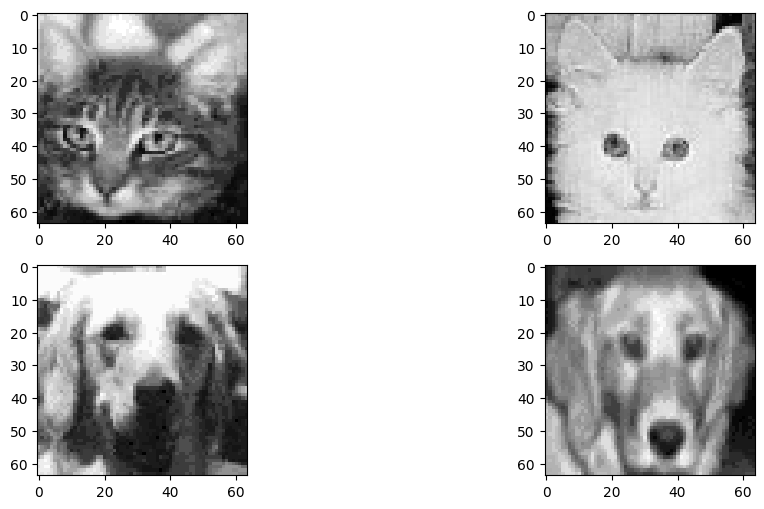

In [28]:
def rotateM(x):
    return np.transpose(np.apply_along_axis(np.flip, 0, x))

def plot_images(indices, data, category, cmap='gray'):
    for idx, i in enumerate(indices):
        plt.subplot(2, 2, idx + 1 + category * 2)
        plt.imshow(rotateM(data.iloc[i, :].values.reshape(64, 64)), cmap=cmap)
        plt.xlabel('')
        plt.ylabel('')

# random selections
ssc = np.random.choice(np.where(Y_cats_dogs == 0)[0], 2, replace=False)
ssd = np.random.choice(np.where(Y_cats_dogs == 1)[0], 2, replace=False)

plt.figure(figsize=(12, 6))
plot_images(ssc, X_cats_dogs, category=0)
plot_images(ssd, X_cats_dogs, category=1)
plt.show()

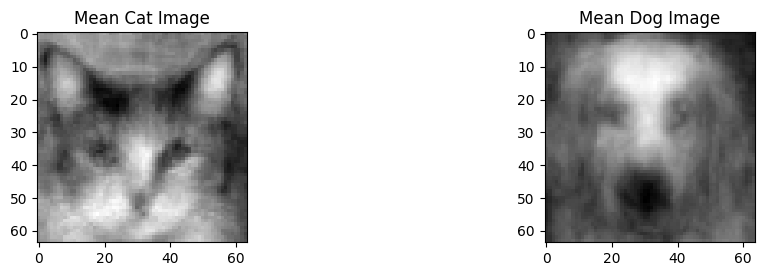

In [29]:
cat_indices = np.where(Y_cats_dogs == 0)[0]  # Indices of cats
dog_indices = np.where(Y_cats_dogs == 1)[0]  # Indices of dogs

mean_cat = np.mean(X_cats_dogs.iloc[cat_indices], axis=0)
mean_dog = np.mean(X_cats_dogs.iloc[dog_indices], axis=0)

mean_cat_image = rotateM(mean_cat.values.reshape(64, 64))
mean_dog_image = rotateM(mean_dog.values.reshape(64, 64))

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(mean_cat_image, cmap='gray')
plt.title('Mean Cat Image')
plt.subplot(2, 2, 2)
plt.imshow(mean_dog_image, cmap='gray')
plt.title('Mean Dog Image')
plt.show()

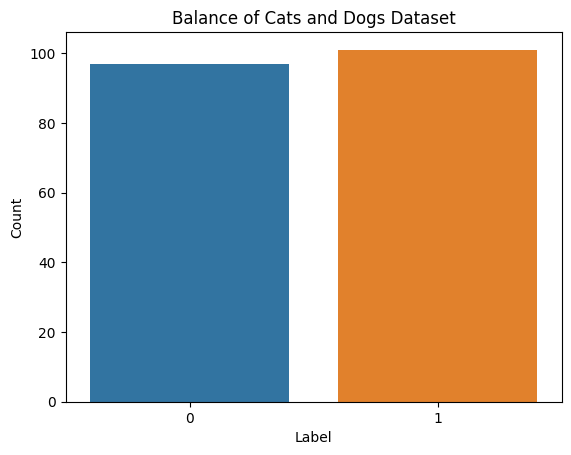

In [30]:
sns.countplot(data=Y_cats_dogs, x='x')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Balance of Cats and Dogs Dataset')
plt.show()

## Setup

### Pipeline and grid search

In [31]:
# Parameter grid for Random Forest (bagging)
params_rf = {
    'classifier__n_estimators': n_estimators,
    'classifier__max_depth': max_depth,
    # 'classifier__min_samples_split': min_samples_split,
    # 'classifier__max_features': ['sqrt', 'log2'],
}

# Parameter grid for Gradient Boosting
params_gb = {
    'classifier__n_estimators': n_estimators,
    'classifier__max_depth': max_depth,
    'classifier__min_samples_split': min_samples_split,
    'classifier__learning_rate': learning_rate,
    
    # TO DO: see if the paramters below are useful
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__reg_alpha': [0, 0.1, 0.5],
    'classifier__reg_lambda': [0, 0.1, 0.5]
}

pipeline = Pipeline([
    ('variance_threshold', VarianceThreshold()),
    ('classifier', rf)
])

def grid_search(X_train, Y_train, model: str):
    if model == 'rf':
        #pipeline.named_steps['feature_selection'].estimator_ = rf
        pipeline.named_steps['classifier'] = rf
        params = params_rf
    elif model == 'gb': 
        #pipeline.named_steps['feature_selection'].estimator_ = gb
        pipeline.named_steps['classifier'] = gb
        params = params_gb
    else:
        raise ValueError('Invalid model name')
    
    grid_search_res = GridSearchCV(pipeline, params, cv=stratified_k_fold, scoring='f1_macro', n_jobs=-1)
    grid_search_res.fit(X_train, np.ravel(Y_train))
        
    return grid_search_res

def get_feature_importance(grid_search_res, X):
    # feature importances from the best estimator
    best_estimator = grid_search_res.best_estimator_.named_steps['classifier']
    feature_importances = best_estimator.feature_importances_
    # feature names for features kept after filtering
    variance_threshold = grid_search_res.best_estimator_.named_steps['variance_threshold']
    
    feature_names = X.columns[variance_threshold.get_support()]

    # dataframe for feature importances
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    top_10_features = feature_importance_df.sort_values('importance', ascending=False).head(10)

    return feature_importance_df, top_10_features

### Plots and displays

In [32]:
def plot_learning_trend(grid_search_res, model_name, noise, data='cancer'):
    results = grid_search_res.cv_results_
    
    # mean test scores for each estimator with the same value of n_estimators
    mean_scores = []
    for n in n_estimators:
        mask = results['param_classifier__n_estimators'] == n
        if np.any(mask):
            mean_scores.append(np.mean(results['mean_test_score'][mask]))
        else:
            mean_scores.append(np.nan)
    
    plt.figure(figsize=(8, 6))
    plt.plot(n_estimators, mean_scores, marker='o')
    plt.xlabel('n estimators')
    plt.ylabel('cv score')
    plt.title(f'Learning trend for different n_estimators ({model_name_map[model_name]}, {noise * 100}% noise)')
    plt.grid(True)
    plt.savefig(f"imgs_{data}/{model_name}_plot_n_estimators_noise_{noise}.png")
    #plt.show()

def plot_max_depth(grid_search_res, model_name, noise, data='cancer'):
    results = grid_search_res.cv_results_
    
    plt.figure(figsize=(8, 6))
    ## Changed
    for d in max_depth:
        mask_d = results['param_classifier__max_depth'] == d
        mean_scores = []
        for n in n_estimators:
            mask_n = results['param_classifier__n_estimators'] == n
            mask = mask_d & mask_n
            if np.any(mask):
                mean_scores.append(np.mean(results['mean_test_score'][mask]))
            else:
                mean_scores.append(np.nan)
        print(d, mean_scores)
        plt.plot(n_estimators, mean_scores, marker='o', label=f'max_depth={d}')
        
    plt.ylabel('cv score')
    plt.title(f'Learning trend for different max_depth ({model_name_map[model_name]}, {noise * 100}% noise)')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"imgs_{data}/{model_name}_plot_max_depth_noise_{noise}.png")
    #plt.show()
    
def plot_confusion_matrix(Y_test, Y_test_pred, labels, model_name, noise, data='cancer'):
  # confusion matrix and display
  cm = confusion_matrix(Y_test, Y_test_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  # plot the confusion matrix
  cm_display.plot()
  plt.title(f'Confusion matrix ({model_name_map[model_name]}, {noise * 100}% noise)')
  plt.savefig(f"imgs_{data}/{model_name}_confusion_matrix_noise_{noise}.png")
  #plt.show()
  
def show_classification_report(X_test, Y_test, grid_search_res, model_name: str, noise, data='cancer'):
  Y_test_pred = grid_search_res.predict(X_test)
  best_params = grid_search_res.best_params_
  print(f"Classification Report (data={data})\nOptimal parameters {best_params} ({model_name_map[model_name]}, noise: {noise * 100}%)\n",
      classification_report(Y_test, Y_test_pred)) 

def show_feature_importance(top_10_features, model_name: str, noise: float, data='cancer'):
    plt.figure(figsize=(8, 6))
    plt.bar(top_10_features['feature'], top_10_features['importance'], color='steelblue')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title(f'Top 10 Features ({model_name}, {noise * 100:.1f}% Noise)')
    plt.xticks(rotation=45, ha='right')
    plt.savefig(f"imgs_{data}/{model_name}_top_10_features_noise_{noise}.png", bbox_inches='tight')
    #plt.show()
    
def plot_2_top_features(top_10_features, labels, X, Y, model_name: str, noise: float, data='cancer'):
    # 2 most important features
    top_2_features = top_10_features['feature'].head(2).values
    # colormap
    cmap = plt.get_cmap('viridis')
    class_colors = cmap(np.linspace(0, 1, len(labels)))
    
    # check if X and Y have the same indices
    assert (X.index == Y.index).all()
    assert len(X) == len(Y)
    
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(labels):
        mask = Y['x'] == cls
        indices = np.array(Y.loc[mask].index)

        valid_indices_mask = np.in1d(indices, X.index)
        if not valid_indices_mask.all():
            raise ValueError("Some indices in `indices` are out of bounds for `X`.")

        X_filtered = X.loc[indices[valid_indices_mask]]

        plt.scatter(
            # filter rows and select top column
            X_filtered[top_2_features[0]],
            X_filtered[top_2_features[1]],
            color=class_colors[i],
            label=f'Class {cls}',
            alpha=0.7
        )

    plt.xlabel(top_2_features[0])
    plt.ylabel(top_2_features[1])
    plt.title(f'Class Division with Top 2 Features ({model_name}, {noise * 100:.1f}% Noise)')
    plt.legend()
    plt.savefig(f"imgs_{data}/{model_name}_class_division_top_2_features_noise_{noise}.png", bbox_inches='tight')
    #plt.show()

def ranking_of_pixels(feature_importance_df,model_name: str, noise: float, data='cancer'):
    # feature importance values
    feature_importances = feature_importance_df['importance'].values
    image_shape = (64, 64) 
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    #cat
    axes[0].imshow(feature_importances.reshape(image_shape), cmap=plt.cm.Blues)
    axes[0].imshow(mean_cat_image, cmap='gray', alpha=0.5)
    # dog
    heatmap2 = axes[1].imshow(feature_importances.reshape(image_shape), cmap=plt.cm.Blues)
    axes[1].imshow(mean_dog_image, cmap='gray', alpha=0.5)
    # colorbar
    fig.colorbar(heatmap2, ax=axes, orientation='vertical', fraction=0.05, pad=0.04)
    plt.suptitle(f'Pixel Importance Ranking ({model_name}, {noise * 100:.1f}% Noise)')
    plt.subplots_adjust(right=0.8)
    plt.savefig(f"imgs_{data}/{model_name}_pixel_importance_noise_{noise}.png", bbox_inches='tight')
    #plt.show()

### Main processes

In [33]:
def process_noise(model_name, noise, data='cancer'):
    # split dataset
    if data == 'cancer':
        X_train, X_test, Y_train, Y_test = splits(X_cancer, Y_cancer, noise)
        labels = Y_cancer['x'].unique()
    if data == 'cats_dogs':
        X_train, X_test, Y_train, Y_test = splits(X_cats_dogs, Y_cats_dogs, noise)
        labels = Y_cats_dogs['x'].unique()

    # grid search and metrics
    grid_search_res = grid_search(X_train, Y_train, 'rf')
    balanced_ac_score = balanced_accuracy_score(Y_test, grid_search_res.predict(X_test))
    f1_scores = f1_score(Y_test, grid_search_res.predict(X_test), average='macro')
    
    # show results
    with print_lock:
        plot_learning_trend(grid_search_res, model_name, noise, data)
        show_classification_report(X_test, Y_test, grid_search_res, model_name, noise, data)
        plot_confusion_matrix(Y_test, grid_search_res.predict(X_test), labels, model_name, noise, data)
        plot_max_depth(grid_search_res, model_name, noise, data)
        feature_importance_df, top_10_features = get_feature_importance(grid_search_res, X_train)
        if data == 'cancer':
            show_feature_importance(top_10_features, model_name, noise, data)
            plot_2_top_features(top_10_features, labels, X_train, Y_train, model_name, noise, data)
        if data == 'cats_dogs':
            ranking_of_pixels(feature_importance_df, model_name, noise, data)
    
    return {'noise': noise, 'grid_search_res': grid_search_res, 'balanced_ac_score': balanced_ac_score, 'f1_score': f1_scores}

In [34]:
def main_parallel(model_name: str, data='cancer'):
    logging.info(f'Starting main function with model_name: {model_name}')
    
    results = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for noise in noises:
            logging.info(f'Submitting task for noise level: {noise}')
            future = executor.submit(process_noise, model_name, noise, data)
            futures.append(future)
        
        for i, future in enumerate(concurrent.futures.as_completed(futures)):
            result = future.result()
            results.append(result)
            logging.info(f'Task {i + 1} completed with result: {result}')
            
        # print a summary with all the reuslts obtianed
        results = sorted(results, key=lambda x: x['noise'], reverse=True)
        logging.info('Summary of results:')
        for result in results:
            logging.info(f'Noise: {result["noise"]}, Balanced Accuracy Score: {result["balanced_ac_score"]}, F1 Score: {result["f1_score"]}')
                
    logging.info('All tasks completed.')
    
    return results

## Test

Classification Report (data=cats_dogs)
Optimal parameters {'classifier__max_depth': 6, 'classifier__n_estimators': 15} (Gradient Boosting, noise: 0.0%)
               precision    recall  f1-score   support

           0       0.73      0.80      0.76        20
           1       0.78      0.70      0.74        20

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.75      0.75      0.75        40

None [0.7899451008473565, 0.7384129443135654, 0.7696258616047844, 0.7762341745042853, 0.7627148230188308, 0.7504564564262131, 0.7575926137532281]
2 [0.7377098591428437, 0.7233633866127045, 0.7243638004736569, 0.7165603850920714, 0.7165184407035173, 0.7035668818436956, 0.7098476262779357]
4 [0.7521758011380654, 0.7580158730158729, 0.7876971929950399, 0.7616917529935597, 0.7495104130713018, 0.7434671487758645, 0.7511381594380039]
6 [0.7902890161912719, 0.7391854747150314, 0.7696258616047844, 0.7627877844629606, 0.768

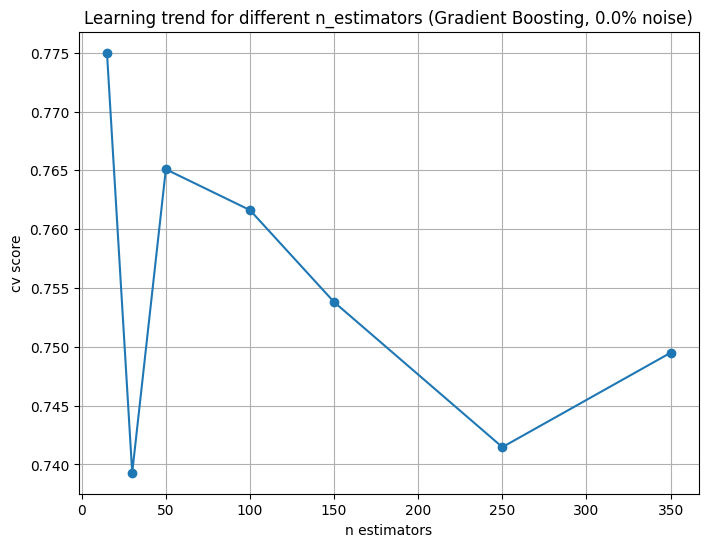

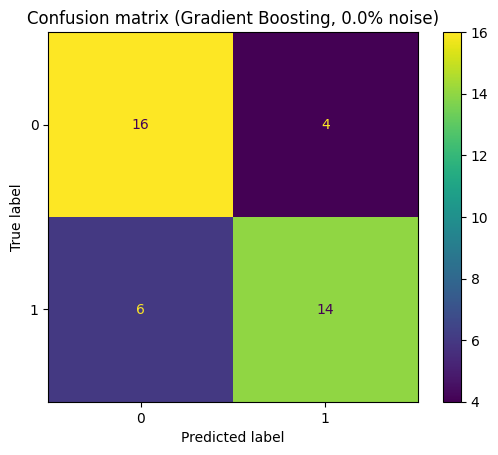

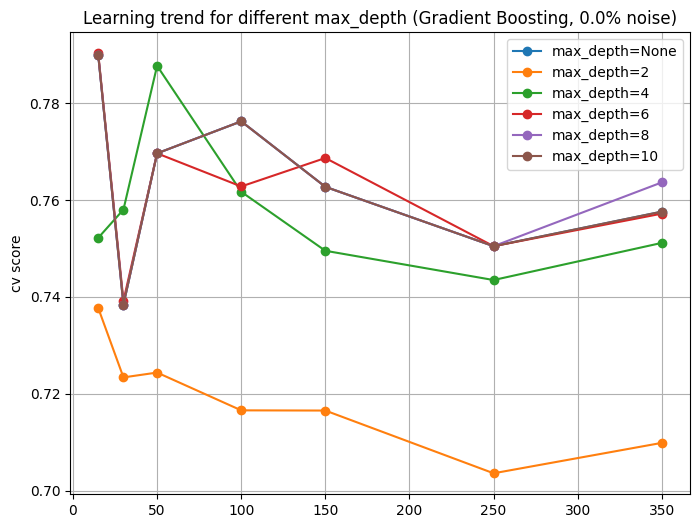

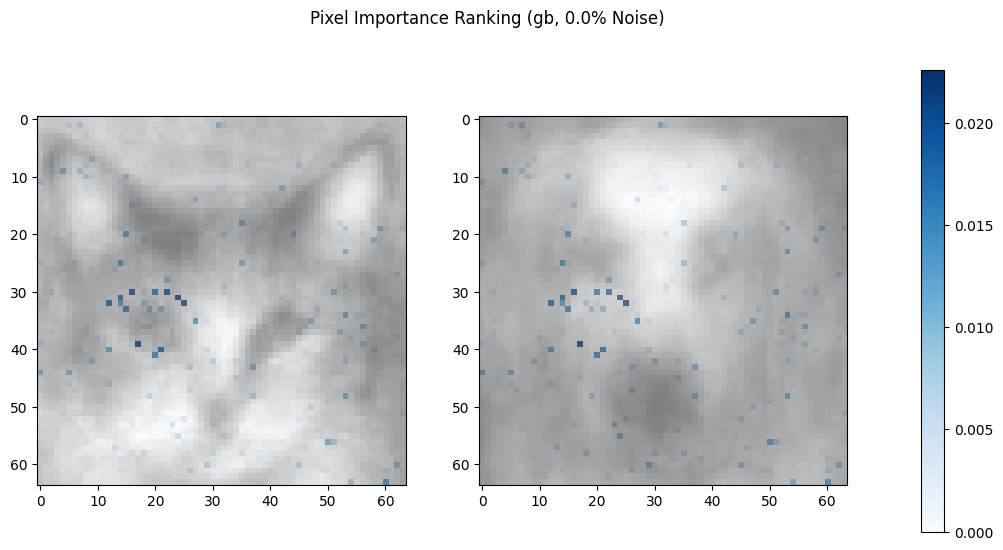

In [35]:
result_cancer = process_noise('gb', 0.0, 'cats_dogs')

In [36]:
%%time

#results_cancer_rf = main_parallel('rf', 'cancer')
#results_cancer_gb = main_parallel('gb', 'cancer')

CPU times: total: 0 ns
Wall time: 0 ns


In [37]:
#results_cats_dogs_rf = main_parallel('rf', 'cats_dogs')
#results_cats_dogs_gb = main_parallel('gb', 'cats_dogs')